In [1]:
using Revise
using Plots
using LinearAlgebra

# レナードジョーンズポテンシャル
$$
U(r) = 4\epsilon\left[\left(\frac{\sigma}{r}\right)^p-\left(\frac{\sigma}{r}\right)^q\right]
$$
加わる力は
$$
F(r) = -\frac{d}{dr}U(r) = 4\epsilon\left(p\frac{\sigma^{p}}{r^{p+1}}-q\frac{\sigma^{q}}{r^{q+1}}\right)
$$

In [2]:
potential(r,ϵ,σ,p=12,q=6)=4ϵ*((σ/r)^p - (σ/r)^q)
force(r,ϵ,σ,p=12,q=6)=4ϵ/r*(p*(σ/r)^p - q*(σ/r)^q)

force (generic function with 3 methods)

## 原子モデル

In [3]:
mutable struct Atom
    x::Vector{Float64}
    v::Vector{Float64}
    m::Float64
end

### 希ガス分子に対するLennard-Jones パラメータ

|  | $\sigma$[nm] | $\epsilon$[J] | $\epsilon/k_{B}$[K] | m [kg] |
|:---:|:---:|:---:|:---:| :---:|
| Ne | 0.274 | $0.50 \times 10^{-21}$ | 36.2 |  
| Ar | 0.340 | $1.67 \times 10^{-21}$ | 121 |$6.634 \times 10^{-26}$|   
| Kr | 0.365 | $2.25 \times 10^{-21}$ | 163 |
| Xe | 0.398 | $3.20 \times 10^{-21}$ | 232 |  

### Argonの場合

In [4]:
ϵ = 1.67
σ = 0.34
m = 6.63e-3

f_ar(r) = force(r,ϵ,σ)

f_ar (generic function with 1 method)

# 速度Verlet
$$
a(t) = \frac{F(r(t))}{m} \\
r(t+\Delta t) = r(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^{2} \\
v(t+\Delta t) = v(t) + \frac{a(t)+a(t+\Delta t)}{2}\Delta t
$$

In [5]:
function calc_acc(as,f)
    accs=[]
    for a1 in as
        acc = [0.0,0.0]
        for a2 in as
            if a1 != a2
                acc += f(norm(a1.x-a2.x))/a1.m*(a1.x-a2.x)/norm(a1.x-a2.x)
            end
        end
        push!(accs,acc)
    end
    return accs 
end

function update_x!(as,accs,Δt)
    for (a, acc) in zip(as,accs)
        a.x +=  a.v*Δt + acc*Δt^2/2
    end
end

function update_v!(as,accs,acc_nexts,Δt)
    for (a, acc,acc_next) in zip(as,accs,acc_nexts)
        a.v +=  (acc+acc_next)*Δt/2
    end
end

update_v! (generic function with 1 method)

┌ Info: Saved animation to /Users/hitoshi/Julia/Lennard-Jones/multiparticles_LJ.gif
└ @ Plots /Users/hitoshi/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/hitoshi/Julia/Lennard-Jones/multiparticles_LJ.gif")
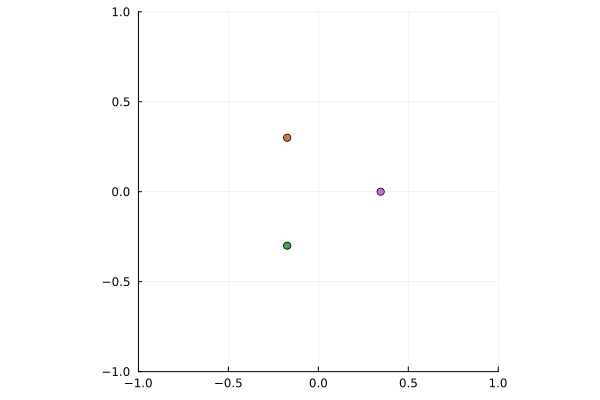

In [ ]:
a1 = Atom([-0.3/√3,0.3],[0.0,0.0],m)
a2 = Atom([-0.3/√3,-0.3],[0.0,0.0],m)
a3 = Atom([0.3*2/√3,0.0],[0.0,0.0],m)
as = [a1,a2,a3]

Δt = 1e-6
n = 5e5
samp = 1000

anim = Animation()
for i=0:n
    if i%samp == 0
        plt = plot([],[],st=:scatter,xlims=(-1.0,1.0),ylims=(-1.0,1.0),label="",aspect_ratio=:equal)
        for a in as
            plot!([a.x[1]],[a.x[2]],st=:scatter,label="")
        end
        frame(anim,plt)
    end
    accs = calc_acc(as,f_ar)
    update_x!(as,accs,Δt)
    acc_nexts = calc_acc(as,f_ar)
    update_v!(as,accs,acc_nexts,Δt)
end
gif(anim,"multiparticles_LJ.gif",fps=30)